## Sentiment Analysis for Online Reviews

In [1]:
# libraries to import
import string
import math
import pandas as pd
import numpy as np
import nltk as nltk
import scipy as sp
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer  
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### a) Downloading, reading and analyzing datasets

In [2]:
# load data in the right> format according to readme files
yelp=pd.read_csv("sentiment_labelled_sentences\yelp_labelled.txt",delimiter="\t", names=["Sentence", "Label"])
imdb=pd.read_csv("sentiment_labelled_sentences\imdb_labelled.txt",delimiter="\t", names=["Sentence", "Label"])
amazon=pd.read_csv("sentiment_labelled_sentences\labelled_amazon.txt",delimiter="\t", names=["Sentence", "Label"])

In [3]:
# check if data is balanced in all three dataframes

# yelp
ones_yelp = len(yelp[yelp['Label'] == 1])
zeros_yelp = len(yelp[yelp['Label'] == 0])
print('Number of 1s in Yelp:', ones_yelp)
print('Number of 0s in Yelp:', zeros_yelp)

#imdb
ones_imdb = len(imdb[imdb['Label'] == 1])
zeros_imdb = len(imdb[imdb['Label'] == 0])
print('Number of 1s in Imdb:', ones_imdb)
print('Number of 0s in Imdb:', zeros_imdb)

#amazon
ones_amazon = len(amazon[amazon['Label'] == 1])
zeros_amazon = len(amazon[amazon['Label'] == 0])
print('Number of 1s in Amazon:', ones_amazon)
print('Number of 0s in Amazon:', zeros_amazon)

Number of 1s in Yelp: 500
Number of 0s in Yelp: 500
Number of 1s in Imdb: 386
Number of 0s in Imdb: 362
Number of 1s in Amazon: 500
Number of 0s in Amazon: 500


The data in the Yelp and Amazon files is balanced because there are the same number of 1s and 0s as labels. 
The data in the Imdb file can be considered almost balancen because the number of 1s and 0s is almost the same (386 and 362, respectively). The ratio of 1s to 0s is 386/362 = 1.067.

#### b) Pre-processing datasets

In [4]:
# function to preprocess data
def preprocessing(data):
    stop_words = set(stopwords.words('english')) # find stop words in English language
    lemmatizer = WordNetLemmatizer() # declare nltk lemmatizer

    # iterate through every sentence and replace it by itself lemmatized, without punctuation and without stop words
    for i in data['Sentence'].index:
    
        # remove punctuation
        sentence_no_punct = ''
        for char in (data.at[i, 'Sentence']):
            if char not in string.punctuation:
                sentence_no_punct = sentence_no_punct + char
        (data.at[i, 'Sentence']) = sentence_no_punct

        word_tokens = word_tokenize(data.at[i, 'Sentence'])
        
        # remove stop words and lemmatize
        word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words]
        word_tokens = [lemmatizer.lemmatize(word, 'v') for word in word_tokens]
        word_tokens = [lemmatizer.lemmatize(word, 'a') for word in word_tokens]
        
        # remove conjunction words
        word_tokens = [word for word in word_tokens if word[-2:] != 'nt']
        (data.at[i, 'Sentence']) = ' '.join(word_tokens)
        
    return data

In [5]:
# convert all letters to lower case
yelp = yelp.applymap(lambda s:s.lower() if type(s) == str else s)
imdb = imdb.applymap(lambda s:s.lower() if type(s) == str else s)
amazon = amazon.applymap(lambda s:s.lower() if type(s) == str else s)

# lemmatize, remove punctuation, remove stop words
preprocessing(yelp)
preprocessing(imdb)
preprocessing(amazon);

For this part, we decided to convert all sentences to lower case, so that the same word with some upper case letters and without them would not be detected as different words since we are using the string type which takes into account their differences. 

We also stripped the sentences of stop words because they do not add any meaning as the same stop words appear in many different sentences.

Additionally, we removed the punctuation because it does not add any meaning to the word analysis exercise we will do in this question. 

We also lemmatized all the words because we are interested in knowing which class of words they belong to in order to understand the meaning of the sentence and not whether they are a noun, adjective, etc.

We finally removed words with the conjunction "n't" because these are also meaningless words like "isn't" and "didn't". They are basically stop words but are not caught by the stop word checker because of the extra "n't".

#### c) Split training and testing data

In [6]:
# split the three datasets into training and testing data according to the specifications

def split_data(data):
    data.reset_index(drop=True)
    training = (data.query('Label == 1' )).head(400).append((data.query('Label == 0' )).head(400))
    testing = (data.query('Label == 1' )).tail(100).append((data.query('Label == 0' )).tail(100))
    return training, testing

In [7]:
# split yelp
training_yelp, testing_yelp = split_data(yelp)

# split imdb
training_imdb, testing_imdb = split_data(imdb)

# split amazon
training_amazon, testing_amazon = split_data(amazon)

In [8]:
# concatenate training and testing data for all files
train_data = training_yelp.append(training_imdb, ignore_index=True).append(training_amazon, ignore_index=True)
print(np.shape(train_data)) # this not exactly 2400? Because IMDB does not reach 800 data points...but why

test_data = testing_yelp.append(testing_imdb, ignore_index=True).append(testing_amazon, ignore_index=True)
print(np.shape(test_data)) 

(2348, 2)
(600, 2)


#### d) Bag of Words model

For this question we cannot use the testing set to create the dictionary of unique words because the model needs to be created with the training set so that we can use the testing set as new data to test our model's ability to generalize. If we create the dictionary with the testing data, we are essentially using all the data as training data and would need to look for another set of new data to test the classifier.

In [22]:
# create set of unique words in training set
word_dictionary = {}

# iterate through every word or every sentence and store it in dictionary with count 0 (the count will be updated
# later when we iterate through both testing and training set
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    for word in word_tokens_training:
        word_dictionary[word] = 0
        
# count the number of occurrences of each word in dictionary in training set
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    for word in word_tokens_training:
        if word in word_dictionary:
            word_dictionary[word] += 1
            
# count the number of occurences of each word in dictionary in testing set  
for i in test_data.index:
    word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
    for word in word_tokens_testing:
        if word in word_dictionary:
            word_dictionary[word] += 1

# create one feature vector per review
feature_column = [] # list to store the feature vectors and add to dataframe at the end
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    feature_vector = np.zeros(len(word_dictionary.keys())) # to store feature vector in each iteration
    for j, dict_word in enumerate(word_dictionary.keys()):
        if dict_word in word_tokens_training:
            feature_vector[j] = math.log(word_dictionary[dict_word] + 1) # apply log normalization
    feature_column.append(feature_vector) 
train_data['Vectors'] = feature_column

feature_column = [] # list to store the feature vectors and add to dataframe at the end
for i in test_data.index:
    word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
    feature_vector = np.zeros(len(word_dictionary.keys())) # to store feature vector in each iteration
    for j, dict_word in enumerate(word_dictionary.keys()):
        if dict_word in word_tokens_testing:
            feature_vector[j] = math.log(word_dictionary[dict_word] + 1) # apply log normalization
    feature_column.append(feature_vector) 
test_data['Vectors'] = feature_column

In [21]:
# report 2 feature vectors
with open('2d.txt', 'w') as f:
    f.write('Vector1\n')
    f.write(str(test_data['Vectors'][0]).replace('\n', ''))
    f.write('\n\n')
    f.write('Vector2\n')
    f.write(str(test_data['Vectors'][1]).replace('\n', ''))

#### e) Pick postprocessing strategy

We decided to use log normalization as our postprocessing strategy to make data less skewed and focus on relative differences by bringing the feature vectors into the log space. We added the normalization step in the code for d) as we were constructing the feature vectors in order to reduce the number of iterations we need to go through the data.

We decided not to apply mean subtraction and division by standard deviation there are some standard deviations that are equal to zero, resulting in a divide by zero error. Also, the number of dimensions (words) of the feature vectors is significant, so choosing L1 or L2 norm might result in similar distance measures for sentences with different words, so we discarded these techniques. 

#### f) Sentiment prediction

In [28]:
# function to perform sentiment analysis
def Sentiment_Analysis(train_data, train_labels, test_data, test_labels):
    # split training and testing data into X (data) and Y (labels)
    x_train = list(train_data) 
    y_train = list(train_labels)

    x_test = list(test_data) 
    y_test = list(test_labels)

    # initialize and fit logistic regression model with training data
    lr = LogisticRegression(solver = 'lbfgs', max_iter = 10000)
    lr.fit(x_train, y_train)

    # predict the result for the testing data
    lr_pred = lr.predict(x_test) 
    
    lr_weight = lr.coef_

    # calculate accuracy
    lr_acc = accuracy_score(lr_pred, y_test)

    # initialize and fit naive bayes model gaussian prior with training data
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)

    # predict the results for the test set
    gnb_pred = gnb.predict(x_test)
    
    gnb_weight = gnb.theta_

    # calculate accuracy
    gnb_acc = accuracy_score(gnb_pred, y_test)

    # confusion matrix calculations
    
    cfn_matrix_lr = confusion_matrix(y_test, lr_pred)
    cfn_matrix_gnb = confusion_matrix(y_test, gnb_pred)
    
    # return accuracy and confusion matrices for logistic regression and naive bayes
    return lr_acc, gnb_acc, cfn_matrix_lr, cfn_matrix_gnb, lr_weight, gnb_weight

[[260  40]
 [ 52 248]]
[[234  66]
 [ 59 241]]


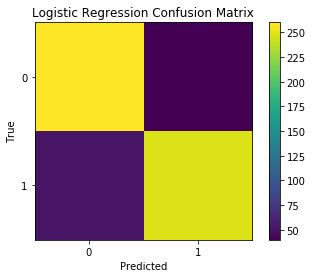

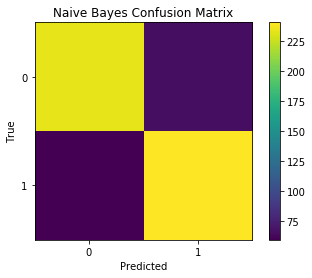

In [29]:
lr_acc, gnb_acc, cfn_matrix_lr, cfn_matrix_gnb, \
lr_weight, gnb_weight = Sentiment_Analysis(train_data['Vectors'], train_data['Label'], \
                                                 test_data['Vectors'], test_data['Label'])

# display logistic regression confusion matrix
print(cfn_matrix_lr)

# display the matrix in an intuitive way
fig, ax = plt.subplots()
plt.imshow(cfn_matrix_lr)
plt.colorbar()
plt.title('Logistic Regression Confusion Matrix')
classes = [0,1]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');
plt.savefig('LR_ConfMatrix')

# display naive bayes confusion matrix
print(cfn_matrix_gnb)

# display the matrix in an intuitive way
fig, ax = plt.subplots()
plt.imshow(cfn_matrix_gnb)
plt.colorbar()
plt.title('Naive Bayes Confusion Matrix')
classes = [0,1]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');
plt.savefig('NB_ConfMatrix')

In [26]:
# pring both accuracies
print("Logistic Regression accuracy is: ", lr_acc)
print("Naive Bayes accuracy is: ", gnb_acc)

Logistic Regression accuracy is:  0.8466666666666667
Naive Bayes accuracy is:  0.7916666666666666


In [50]:
# inspect weights in lr
words = list(word_dictionary.keys())
for i, weight in enumerate(lr_weight[0]):
    if weight > 1:
        print (words[i])

beautiful
delight
tender
realize
wonderful
delicious
fantastic
satisfy
perfect
awesome
soundtrack
struggle
15
1010
role
cinema
sturdy


In [53]:
# inspect weights in gnb
for i, weight in enumerate(gnb_weight[0]):
    if weight > 0.18:
        print (words[i])

place
service
food
good
like
go
time
one
get
bad
make
would
work
movie
film
phone


#### (g) N-gram model

In [54]:
# function to create n-gram dictionary
def ngram_dict(n, train_data, test_data):
    # create set of unique words in training set
    word_dict = {}

    # iterate through every word or every sentence and store it in dictionary with count 0 (the count will be updated
    # later when we iterate through both testing and training set
    for i in train_data.index:
        word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_training)):
            if j+n < len(word_tokens_training):
                words = ' '.join([word_tokens_training[k] for k in range(j,j+n)])
                word_dict[words] = 0
    
    # count the number of occurences of each word in dictionary in training set
    for i in train_data.index:
        word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_training)):
            if j+n < len(word_tokens_training):
                words = ' '.join([word_tokens_training[k] for k in range(j,j+n)])
                if words in word_dict:
                    word_dict[words] += 1
    # count the number of occurences of each word in dictionary in testing set  
    for i in test_data.index:
        word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_testing)):
            if j+n < len(word_tokens_testing):
                words = ' '.join([word_tokens_testing[k] for k in range(j,j+n)])
                if words in word_dict:
                    word_dict[words] += 1
    return word_dict

# function to obtain n-gram feature vectors
def ngram_feature_vec(n, data, word_dict):
    feature_vecs = []
    for i in data.index:
        word_tokens = word_tokenize(data.at[i, 'Sentence'])
        
        # create a lst of ngrams for this review
        ngram_lst = []
        for j in range(len(word_tokens)):
            if j+n < len(word_tokens):
                ngram_lst.append(' '.join([word_tokens[k] for k in range(j,j+n)]))
        
        feature_vector = np.zeros(len(word_dict.keys())) # to store feature vector of this review
        for k, dict_word in enumerate(word_dict.keys()):
            if dict_word in ngram_lst:
                feature_vector[k] = math.log(word_dict[dict_word] + 1) # apply log normalization
                
        feature_vecs.append(feature_vector) 
    return feature_vecs

In [55]:
# implement the ngram model for n = 2

word_dict_n = ngram_dict(2, train_data, test_data)

train_data['Vectors_2gram'] = ngram_feature_vec(2, train_data, word_dict_n)

test_data['Vectors_2gram'] = ngram_feature_vec(2, test_data, word_dict_n)

In [56]:
# perform sentiment analysis with gram results
lr_acc_2, gnb_acc_2, cfn_matrix_2_lr, cfn_matrix_2_gnb, lr_weight_2, gnb_weight_2 = Sentiment_Analysis(train_data['Vectors_2gram'], train_data['Label'], \
                                                 test_data['Vectors_2gram'], test_data['Label'])

In [57]:
print("Logistic Regression accuracy is: ", lr_acc_2)
print("Naive Bayes accuracy is: ", gnb_acc_2)

Logistic Regression accuracy is:  0.6966666666666667
Naive Bayes accuracy is:  0.6666666666666666


[[260  40]
 [ 52 248]]
[[234  66]
 [ 59 241]]


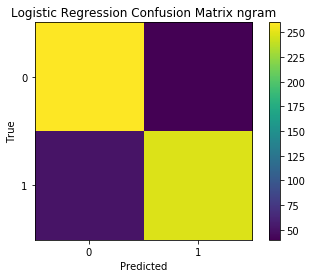

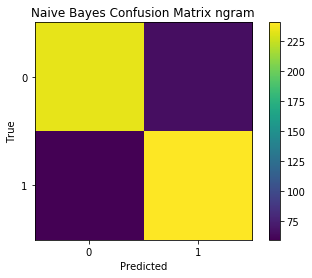

In [58]:
# display logistic regression confusion matrix
print(cfn_matrix_lr)

# display the matrix in an intuitive way
fig, ax = plt.subplots()
plt.imshow(cfn_matrix_lr)
plt.colorbar()
plt.title('Logistic Regression Confusion Matrix ngram')
classes = [0,1]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');
plt.savefig('LR_ConfMatrix_n')

# display naive bayes confusion matrix
print(cfn_matrix_gnb)

# display the matrix in an intuitive way
fig, ax = plt.subplots()
plt.imshow(cfn_matrix_gnb)
plt.colorbar()
plt.title('Naive Bayes Confusion Matrix ngram')
classes = [0,1]
ax.set(xticks=classes,yticks=classes,xticklabels=classes,yticklabels=classes,ylabel='True',xlabel='Predicted');
plt.savefig('NB_ConfMatrix_n')

In [67]:
# inspect weights in lr
words = list(word_dict_n.keys())
for i, weight in enumerate(lr_weight_2[0]):
    if weight > 0.9:
        print (words[i])

really good
one best
great place
pretty good
highly recommend
long time
phone work
great product
best phone


In [71]:
# inspect weights in gnb
for i, weight in enumerate(gnb_weight_2[0]):
    if weight > 0.009:
        print (words[i])

go back
ive ever
would recommend
waste time
one bad
see movie


#### PCA

In [72]:
# convert training and testing data to lists
train_matrix = np.matrix((train_data['Vectors']).tolist())
test_matrix = np.matrix((test_data['Vectors']).tolist())

In [73]:
# function to perform PCA on the data using SVD, reducing it to the number of dimensions specified by dim
def my_pca(data, dim):
    data -= np.mean(data, axis = 0)
    
    # perform SVD
    U, S, VTrans = sp.linalg.svd(data)
    
    # find PCA projection space
    components = VTrans[:dim, :].transpose()
    
    return components

In [74]:
# perform PCA to 10, 50 and 100 dimensions
pca_10 = my_pca(train_matrix, 10)

pca_50 = my_pca(train_matrix, 50)

pca_100 = my_pca(train_matrix, 100)

In [75]:
# calculate the mean of both the training and testing data
train_matrix -= np.mean(train_matrix, axis=0)
test_matrix -= np.mean(test_matrix, axis=0)

In [76]:
# reconstruct the data for 10. 50 and 100 dimensions
train_10 = np.array(np.dot(train_matrix, pca_10))
test_10 = np.array(np.dot(test_matrix, pca_10))

train_50 = np.array(np.dot(train_matrix, pca_50))
test_50 = np.array(np.dot(test_matrix, pca_50))

train_100 = np.array(np.dot(train_matrix, pca_100))
test_100 = np.array(np.dot(test_matrix, pca_100))

In [77]:
# perform sentiment analysis on the data with reduced dimensions
lr_acc_pca10, gnb_acc_pca10, cfn_matrix_pca10_lr, cfn_matrix_pca10_gnb, lr_w_10, gnb_w_10  = Sentiment_Analysis(train_10, train_data['Label'], test_10, test_data['Label'])

lr_acc_pca50, gnb_acc_pca50, cfn_matrix_pca50_lr, cfn_matrix_pca50_gnb, lr_w_50, gnb_w_50 = Sentiment_Analysis(train_50, train_data['Label'], test_50, test_data['Label'])

lr_acc_pca100, gnb_acc_pca100, cfn_matrix_pca100_lr, cfn_matrix_pca100_gnb, lr_w_100, gnb_w_100 = Sentiment_Analysis(train_100, train_data['Label'], test_100, test_data['Label'])

In [78]:
# print results
print("PCA 10 \n", "Logistic regression accuracy: ", lr_acc_pca10, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca10)
print("PCA 50 \n", "Logistic regression accuracy: ", lr_acc_pca50, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca50)
print("PCA 100 \n", "Logistic regression accuracy: ", lr_acc_pca100, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca100)

PCA 10 
 Logistic regression accuracy:  0.595 
 Naive Bayes accuracy:  0.6
PCA 50 
 Logistic regression accuracy:  0.685 
 Naive Bayes accuracy:  0.6483333333333333
PCA 100 
 Logistic regression accuracy:  0.705 
 Naive Bayes accuracy:  0.6383333333333333


In [94]:
# inspect weights in lr
words = list(word_dictionary.keys())
print('10\n')
for i, weight in enumerate(lr_w_10[0]):
    if weight > 0.1:
        print (words[i])
print('\n50\n')
for i, weight in enumerate(lr_w_50[0]):
    if weight > 0.3:
        print (words[i])
print('\n100\n')
for i, weight in enumerate(lr_w_100[0]):
    if weight > 0.6:
        print (words[i])

10

place
late
may
bank
rick

50

place
late
bank
beautiful
cakeohhh
hole

100

cape
velvet
street
beer


In [107]:
# inspect weights in gnb
print('10\n')
for i, weight in enumerate(gnb_w_10[0]):
    if weight > 0.0001:
        print (words[i])
print('\n50\n')
for i, weight in enumerate(gnb_w_50[0]):
    if weight > 0.1:
        print (words[i])
print('\n100\n')
for i, weight in enumerate(gnb_w_100[0]):
    if weight > 0.05:
        print (words[i])

10

love
holiday

50

love
cape

100

love
cakeohhh


##### Also want to try on n-gram

In [111]:
# for this part we repeat the procedure above, this time using n-gram model
train_matrix_n = np.matrix((train_data['Vectors_2gram']).tolist())
test_matrix_n = np.matrix((test_data['Vectors_2gram']).tolist())

In [112]:
def my_pca(data, dim):
    data -= np.mean(data, axis = 0)
    
    # perform SVD
    U, S, VTrans = sp.linalg.svd(data)
    
    # find PCA projection space
    components = VTrans[:dim, :].transpose()
    
    return components

In [113]:
pca_10 = my_pca(train_matrix_n, 10)

pca_50 = my_pca(train_matrix_n, 50)

pca_100 = my_pca(train_matrix_n, 100)

In [114]:
train_matrix_n -= np.mean(train_matrix_n, axis=0)
test_matrix_n -= np.mean(test_matrix_n, axis=0)

In [115]:
train_10 = np.array(np.dot(train_matrix_n, pca_10))
test_10 = np.array(np.dot(test_matrix_n, pca_10))

train_50 = np.array(np.dot(train_matrix_n, pca_50))
test_50 = np.array(np.dot(test_matrix_n, pca_50))

train_100 = np.array(np.dot(train_matrix_n, pca_100))
test_100 = np.array(np.dot(test_matrix_n, pca_100))

In [116]:
lr_acc_pca10, gnb_acc_pca10, cfn_matrix_pca10_lr, cfn_matrix_pca10_gnb,lr_w_10,gnb_w_10  = Sentiment_Analysis(train_10, train_data['Label'], test_10, test_data['Label'])

lr_acc_pca50, gnb_acc_pca50, cfn_matrix_pca50_lr, cfn_matrix_pca50_gnb,lr_w_50,gnb_w_50  = Sentiment_Analysis(train_50, train_data['Label'], test_50, test_data['Label'])

lr_acc_pca100, gnb_acc_pca100, cfn_matrix_pca100_lr, cfn_matrix_pca100_gnb, lr_w_100,gnb_w_100  = Sentiment_Analysis(train_100, train_data['Label'], test_100, test_data['Label'])

In [117]:
# print results
print("PCA 10 \n", "Logistic regression accuracy: ", lr_acc_pca10, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca10)
print("PCA 50 \n", "Logistic regression accuracy: ", lr_acc_pca50, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca50)
print("PCA 100 \n", "Logistic regression accuracy: ", lr_acc_pca100, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca100)

PCA 10 
 Logistic regression accuracy:  0.505 
 Naive Bayes accuracy:  0.49833333333333335
PCA 50 
 Logistic regression accuracy:  0.51 
 Naive Bayes accuracy:  0.5383333333333333
PCA 100 
 Logistic regression accuracy:  0.5816666666666667 
 Naive Bayes accuracy:  0.5716666666666667


In [141]:
# inspect weights in lr
words = list(word_dict_n.keys())
print('10\n')
for i, weight in enumerate(lr_w_10[0]):
    if weight > 0.5:
        print (words[i])
print('\n50\n')
for i, weight in enumerate(lr_w_50[0]):
    if weight > 1:
        print (words[i])
print('\n100\n')
for i, weight in enumerate(lr_w_100[0]):
    if weight > 1:
        print (words[i])

10

bank holiday
rick steve
steve recommendation
selection menu

50

selection menu
ravoli chickenwith
le interior
beer 23
server attentive

100

selection menu
ravoli chickenwith
beer 23
server attentive
good beef
pita hummus
right sauce
service huge


In [142]:
# inspect weights in gnb
print('10\n')
for i, weight in enumerate(gnb_w_10[0]):
    if weight > 0.0001:
        print (words[i])
print('\n50\n')
for i, weight in enumerate(gnb_w_50[0]):
    if weight > 0.004:
        print (words[i])
print('\n100\n')
for i, weight in enumerate(gnb_w_100[0]):
    if weight > 0.005:
        print (words[i])

10

stop late
may bank

50

stop late
cakeohhh stuff

100

stop late
le interior
hole wall


#### (g) Algorithm comparison and analysis

See report

# Clustering for Text Analysis

In [9]:
# import libraries
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

#### (A) Document-wise Clustering

In [3]:
# load documents, titles and terms
documents = np.load('science2k-doc-word.npy')
titles_list = [] # list to store titles
with open('science2k-titles.txt') as f: # read titles file and store them
    for i,line in enumerate(f):
        titles_list.append(line.strip())

titles = np.asarray(titles_list) # convert list to array

terms_list = [] # list to store terms
with open('science2k-vocab.txt') as f: # read terms file and store them
    for i,line in enumerate(f):
        terms_list.append(line.strip())

terms = np.asarray(terms_list) # convert list to array

In [4]:
# check correct dimensions
print(documents.shape)
print(titles.shape)
print(terms.shape)

(1373, 5476)
(1373,)
(5476,)


In [5]:
sil = [] # to store silhouette values
ks = [] # to store k values
costs = []

for k in range(2, 21): # loop through each k value and perform k-means, analyzing each case to pick the best one
    kmeans = KMeans(n_clusters = k, max_iter = 10000).fit(documents)
    labels = kmeans.labels_
    
    # determine whether the documents are labeled correctly
    # comparing inertia and silhouette score (metrics that will help us find which k to use)
    costs.append(kmeans.inertia_)
    sil.append(silhouette_score(documents, labels, metric = 'euclidean'))

    ks.append(k)

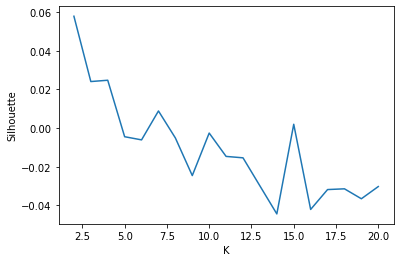

In [6]:
plt.plot(ks, sil) # plot results
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.savefig('Sil_1.png')

Silhouette score is based on mean intra-cluster distance and the mean nearest-cluster distance for each sample. A higher silhouette score means that the model is performing better. This is a good metric because it takes into account how simlar the points are to their cluster center and how different the points are to other clusters and gives us a value that is based on this. 

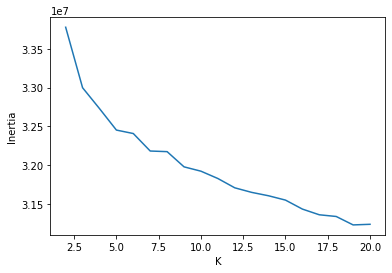

In [7]:
# plot inertia results
plt.plot(ks, costs)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.savefig('costs_1.png')

The inertia is sum of squared distances of samples to their closest cluster center. This is decreasing as we increase the value of k. The best value of k is when you have an "elbow" in this curve, because that is indicating that you have gotten a distance that is close enough to the cluster center. However, this curve is very jagged, is not really approaching zero, and it is difficult to see if there is an elbow, so we decided to use silhouette score.

In [9]:
best_k = ks[np.argmax(sil)] # choose the best k using silhouette score

In [10]:
print(best_k) # print the best k
print(documents.shape) # check correct shapes

2
(1373, 5476)


In [11]:
kmeans = KMeans(n_clusters = best_k, max_iter = 10000).fit(documents) # perform k-means with the best k
labels = kmeans.labels_ # store labels
cluster_centers = kmeans.cluster_centers_ # store cluster centers
documents_avg = np.mean(documents,0) # average feature vector

##### report the top ten words in each cluster with respect to distance from average over all points

In [12]:
word_indices = []
for i in range(best_k): # loop through each cluster
    max_queue = np.zeros((10, 2))
    dist_ccenter_avg = cluster_centers[i] - documents_avg
    for indx, word in enumerate(dist_ccenter_avg):
        if indx < 10:
            max_queue[indx] = (word,indx)
        else:
            if indx == 10:
                max_queue = max_queue[max_queue[:,0].argsort()]
            if word > max_queue[0][0]:
                max_queue[0] = (word,indx)
                max_queue = max_queue[max_queue[:,0].argsort()]
    word_indices.append(max_queue[:,1].astype('int'))

In [13]:
best_words = [[terms[indx] for indx in vec] for vec in word_indices]        

In [14]:
# print the top ten words in each cluster
print('The top ten words in the first cluster are: \n', best_words[0], \
     '\n', 'The top ten words in the second cluster are: \n', best_words[1])

The top ten words in the first cluster are: 
 ['expressed', 'specific', 'binding', 'fig', 'gene', 'proteins', 'expression', 'cells', 'cell', 'protein'] 
 The top ten words in the second cluster are: 
 ['states', 'focus', 'million', 'says', 'researchers', 'scientists', 'world', 'field', 'year', 'years']


##### report the top ten documents for each cluster

In [15]:
doc_indices = []
for i in range(best_k): # loop through each cluster
    max_queue = np.zeros((10, 2))
    j = 0
    for k, label in enumerate(labels): # check points belonging to each label
        if label == i:
            dist_doc = np.linalg.norm(documents[k] - cluster_centers[i])
            if j < 10:
                max_queue[j] = (dist_doc, j)
            else:
                if j == 10:
                    max_queue = max_queue[max_queue[:,0].argsort()]
                if dist_doc > max_queue[0][0]:
                    max_queue[0] = dist_doc
                    max_queue[0] = (dist_doc, j)
                    max_queue = max_queue[max_queue[:,0].argsort()]
            j+=1
    doc_indices.append(max_queue[:,1].astype('int'))

In [16]:
best_docs = [[titles[indx] for indx in vec] for vec in doc_indices]        

In [18]:
# print the top ten documents in each cluster
print('The top ten documents in the first cluster are:')
for doc in best_docs[0]:
    print (doc)

print('\n')

print('The top ten documents in the second cluster are:')
for doc in best_docs[1]:
    print (doc)

The top ten documents in the first cluster are:
"A Time for Restraint"
"Sex Determination in Malaria Parasites"
"A Potassium Channel Protein Encoded by Chlorella Virus PBCV-1"
"Cool Glacial Temperatures and Changes in Moisture Source Recorded in Oman Groundwaters"
"Population Dynamical Consequences of Climate Change for a Small Temperate Songbird"
"How Climate Change Alters Rhythms of the Wild"
"Green, Catalytic Oxidation of Alcohols in Water"
"Giant Birefringent Optics in Multilayer Polymer Mirrors"
"Oxygen Isotopes and Emerald Trade Routes since Antiquity"
"Three-Dimensional Direct Imaging of Structural Relaxation near the Colloidal Glass Transition"


The top ten documents in the second cluster are:
"Language Discrimination by Human Newborns and by Cotton-Top Tamarin Monkeys"
"Thermal, Catalytic, Regiospecific Functionalization of Alkanes"
"Crossed Nanotube Junctions"
"Lunar Impact History from <latex>$^{40}Ar/^{39}Ar$</latex> Dating of Glass Spherules"
"Seeing a World in Grains of 

#### (B) Term-wise Clustering

In [8]:
# for this part we repeat the process in A) using terms insted of documents
words = np.load('science2k-word-doc.npy')
np.shape(words)

(5476, 1373)

In [9]:
sil = [] # to store silhouette values
ks = [] # to store k values

for k in range(2, 21): # loop through each k value and perform k-means, analyzing each case to pick the best one
    kmeans = KMeans(n_clusters = k, max_iter = 10000).fit(words)
    labels = kmeans.labels_
    
    # determine whether the documents are labeled correctly
    sil.append(silhouette_score(words, labels, metric = 'euclidean'))

    ks.append(k)

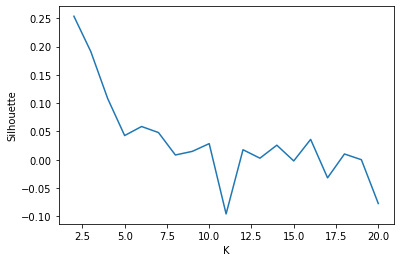

In [10]:
plt.plot(ks, sil) # plot results
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.savefig('Sil_2.png')

In [11]:
best_k = ks[np.argmax(sil)] # choose the best k using silhouette score

In [12]:
print(best_k) # print the best k

2


In [13]:
kmeans = KMeans(n_clusters = best_k, max_iter = 10000).fit(words) # perform k-means with the best k
labels = kmeans.labels_ # store labels
cluster_centers = kmeans.cluster_centers_ # store cluster centers
words_avg = np.mean(words,0) # average feature vector

##### report the top ten words in each cluster with respect to distance from average over all points

In [24]:
doc_indices = []
for i in range(best_k): # loop through each cluster
    max_queue = np.zeros((10, 2))
    dist_ccenter_avg = cluster_centers[i] - words_avg
    for indx, doc in enumerate(dist_ccenter_avg):
        if indx < 10:
            max_queue[indx] = (doc,indx)
        else:
            if indx == 10:
                max_queue = max_queue[max_queue[:,0].argsort()]
            if doc > max_queue[0][0]:
                max_queue[0] = (doc,indx)
                max_queue = max_queue[max_queue[:,0].argsort()]
    doc_indices.append(max_queue[:,1].astype('int'))

In [25]:
best_docs = [[titles[indx] for indx in vec] for vec in doc_indices]        

In [26]:
# print results for both clusters
print('The top ten documents in the first cluster are:')
for doc in best_docs[0]:
    print (doc)

print('\n')

print('The top ten documents in the second cluster are:')
for doc in best_docs[1]:
    print (doc)

The top ten documents in the first cluster are:
"Role of the Mouse ank Gene in Control of Tissue Calcification and Arthritis"
"Function of PI3Kg in Thymocyte Development, T Cell Activation, and Neutrophil Migration"
"Signaling and Circuitry of Multiple MAPK Pathways Revealed by a Matrix of Global Gene Expression Profiles"
"Kinesin Superfamily Motor Protein KIF17 and mLin-10 in NMDA Receptor-Containing Vesicle Transport"
"Central Role for G Protein-Coupled Phosphoinositide 3-Kinase g in Inflammation"
"The Genome Sequence of Drosophila melanogaster"
"An Oral Vaccine against NMDAR1 with Efficacy in Experimental Stroke and Epilepsy"
"Regulated Cleavage of a Contact-Mediated Axon Repellent"
"Noxa, a BH3-Only Member of the Bcl-2 Family and Candidate Mediator of p53-Induced Apoptosis"
"Positional Syntenic Cloning and Functional Characterization of the Mammalian Circadian Mutation tau"


The top ten documents in the second cluster are:
"Bastions of Tradition Adapt to Alternative Medicine"
"NIH

##### report the top ten words for each cluster

In [30]:
word_indices = []
for i in range(best_k): # loop through every cluster
    max_queue = np.zeros((10, 2))
    j = 0
    for k, label in enumerate(labels): # loop through every label
        if label == i:
            dist_word = np.linalg.norm(words[k] - cluster_centers[i])
            if j < 10:
                max_queue[j] = (dist_word, j)
            else:
                if j == 10:
                    max_queue = max_queue[max_queue[:,0].argsort()]
                if dist_word > max_queue[0][0]:
                    max_queue[0] = dist_word
                    max_queue[0] = (dist_word, j)
                    max_queue = max_queue[max_queue[:,0].argsort()]
            j+=1
    word_indices.append(max_queue[:,1].astype('int'))

In [31]:
best_words = [[terms[indx] for indx in vec] for vec in word_indices]        

In [32]:
# print results
print('The top ten words in the first cluster are:')
for word in best_words[0]:
    print (word)

print('\n')

print('The top ten words in the second cluster are:')
for word in best_words[1]:
    print (word)

The top ten words in the first cluster are:
different
shown
org
three
mice
control
two
www
cells
fig


The top ten words in the second cluster are:
model
expression
observed
first
data
sciencemag
science
start
www
protein


# EM Algorithm and Implementation

In [2]:
# import libraries
from sklearn.mixture import GaussianMixture

#### (b) Plot Dataset

In [3]:
# read dataset, removing unnecessary information
with open('faithful.dat.txt') as f:
    data = False
    for i,line in enumerate(f):
        if data == False:
            if line == '    eruptions waiting\n':
                data = True
                df = pd.DataFrame(columns=['eruptions', 'waiting'])
        else:
            line = line.split()
            df.loc[line[0]] = line[1:]

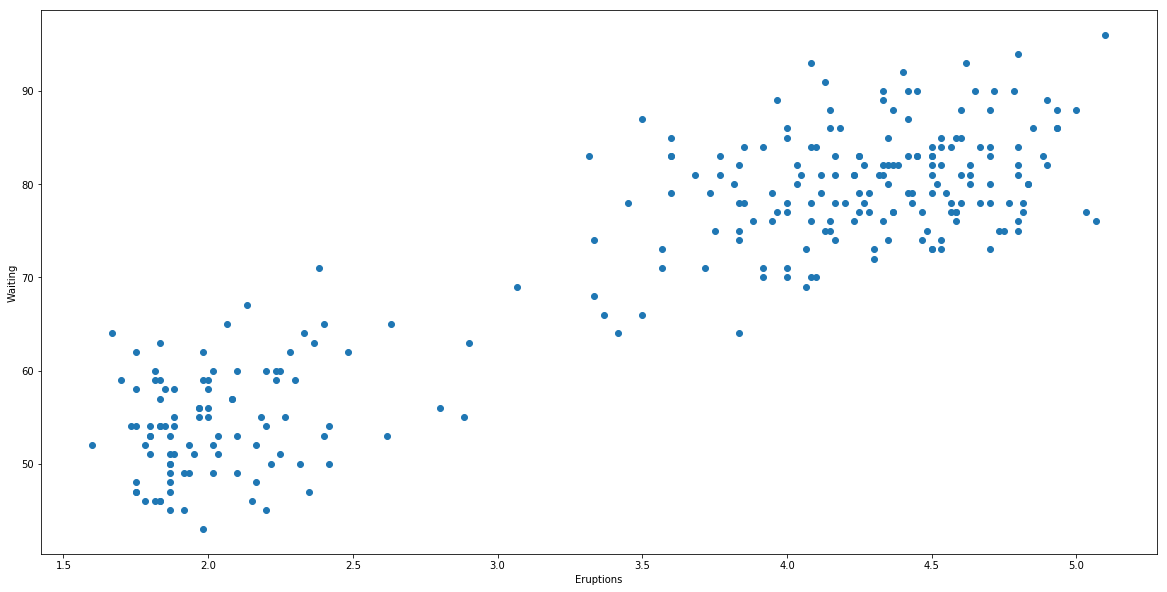

In [25]:
# plot dataframe
plt.figure(figsize=(20,10))
plt.scatter(df['eruptions'].astype('float'), df['waiting'].astype('float'))
plt.xlabel('Eruptions')
plt.ylabel('Waiting');
plt.savefig('Eruptions_Waiting.png')

#### (c) GMM

My termination criterion is when the the means stop changing. This occurs when the previous mean and the current mean is approximately equal. I decided to change the max number of iterations until it acheives this termination criterion to determine what is the best maximum number of iterations.

In [5]:
iterations = [] # list to store the number of iterations
allmeans = [] # list to store means
i = 1
# implement bimodal GMM
gmm = GaussianMixture(n_components=2, warm_start = True, covariance_type = 'spherical', \
                            max_iter = 1, init_params = 'random')

# loop to check the means at every iteration 
while True: 
    gmm.fit(df)
    iterations.append(i)
    means = gmm.means_
    allmeans.append(means)
    if gmm.converged_:
        break
    i+=1

C:\Users\simir\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [6]:
class1 = []
class2 = []
for mean in allmeans:
    class1.append(mean[0])
    class2.append(mean[1])
class1 = np.array(class1)
class2 = np.array(class2)

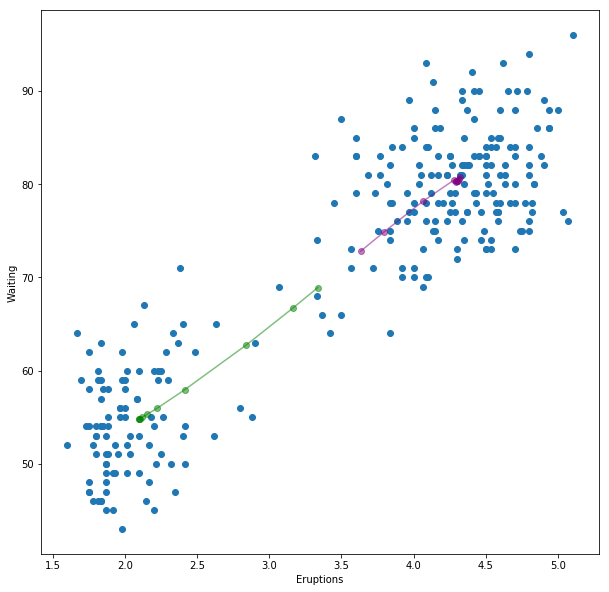

In [7]:
# plot results
plt.figure(figsize=(10, 10))
plt.scatter(df['eruptions'].astype('float'), df['waiting'].astype('float'))
plt.plot(class1[:, 0], class1[:, 1], '-', marker = 'o', c='green', alpha=0.5)
plt.plot(class2[:, 0], class2[:, 1], '-', marker = 'o', c='purple', alpha=0.5)
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.savefig('GMM_Means_0.png')

In [10]:
# run GMM 50 times and plot the number of iterations needed until convergence
num_iters = []
for i in range(50):
    gmm = GaussianMixture(n_components=2, covariance_type = 'spherical', \
                            init_params = 'random')
    gmm.fit(df)
    num_iters.append(gmm.n_iter_)

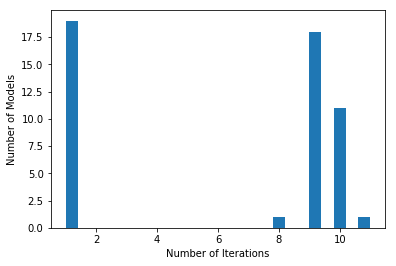

In [11]:
# plot histogram results
plt.hist(num_iters, bins = 25); # plot histogram
plt.xlabel('Number of Iterations')
plt.ylabel('Number of Models')
plt.savefig('Iteration_Hist_1.png')

#### (d) GMM with KMeans

##### Doing it the way the problem asked us to do it.

In [12]:
def kmeans_params(data):
    kmeans_gmm = KMeans(n_clusters = 2, max_iter = 10000).fit(data)
    labels_gmm = kmeans_gmm.labels_
    
    # find means
    x = [0, 0]
    y = [0, 0]
    numx = 0
    numy = 0
    for i, label in enumerate(labels_gmm):
        if label == 0:
            x += np.array(df.iloc[i]).astype(float)
            numx += 1
        else:
            y += np.array(df.iloc[i]).astype(float)
            numy += 1
    means_gmm = [x/numx, y/numy]
    
    # find covariance
    cx = [0, 0]
    cy = [0, 0]
    numx = 0
    numy = 0
    for i, label in enumerate(labels_gmm):
        if label == 0:
            diff = np.array(df.iloc[i]).astype(float) - means_gmm[0]
            cx += np.dot(diff, diff)
            numx += 1
        else:
            diff = np.array(df.iloc[i]).astype(float) - means_gmm[1]
            cy += np.dot(diff, diff)
            numy += 1
    cov_gmm = [cx/numx, cy/numy]
    
    precision_gmm = np.array([1/val[0] for val in cov_gmm])
    
    # find weights (i.e. fraction of data samples in cluster)
    weights_gmm = np.array([0, 0])
    for label in labels_gmm:
        weights_gmm[label] += 1

    weights_gmm = weights_gmm/len(labels_gmm)
    
    return means_gmm, precision_gmm, weights_gmm

In [13]:
mean, precision, weight = kmeans_params(df)

In [15]:
# perform GMM until convergence
iterations = []
allmeans = []
i = 1
gmm = GaussianMixture(n_components=2, warm_start = True, covariance_type = 'spherical', max_iter = 1, \
                      means_init = means, precisions_init = precision, \
                      weights_init = weight)
while True:
    gmm.fit(df)
    iterations.append(i)
    means = gmm.means_

    allmeans.append(means)
    if gmm.converged_:
        break
    i += 1

C:\Users\simir\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [16]:
class1 = []
class2 = []
for mean in allmeans:
    class1.append(mean[0])
    class2.append(mean[1])
class1 = np.array(class1)
class2 = np.array(class2)

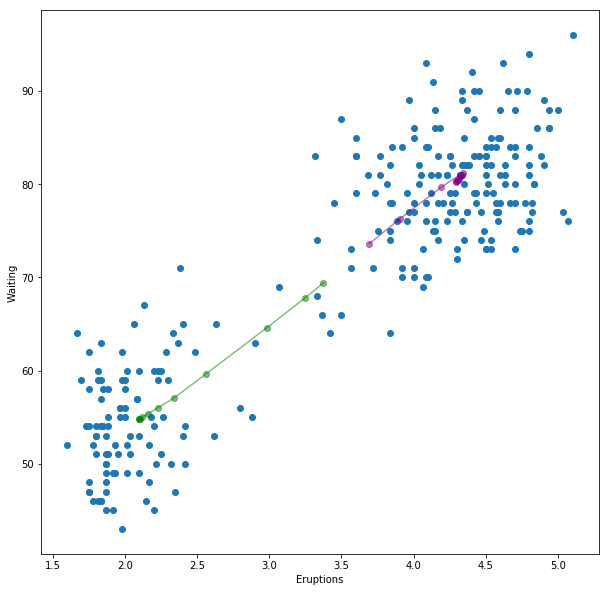

In [17]:
# plot results
plt.figure(figsize=(10, 10))
plt.scatter(df['eruptions'].astype('float'), df['waiting'].astype('float'))
plt.plot(class1[:, 0], class1[:, 1], '-', marker = 'o', c='green', alpha=0.5)
plt.plot(class2[:, 0], class2[:, 1], '-', marker = 'o', c='purple', alpha=0.5)
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.savefig('GMM_Means_1.png')

In [18]:
# run GMM 50 times and plot the number of iterations needed until convergence
num_iters = []
for i in range(50):
    meang, precisiong, weightg = kmeans_params(df)
    gmm = GaussianMixture(n_components=2, covariance_type = 'spherical', \
                          means_init = meang, precisions_init = precisiong, \
                          weights_init = weightg)
    gmm.fit(df)
    num_iters.append(gmm.n_iter_)

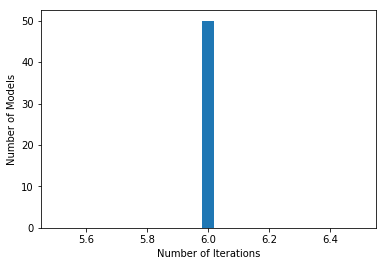

In [19]:
# plot results histogram
plt.hist(num_iters, bins = 25);
plt.xlabel('Number of Iterations')
plt.ylabel('Number of Models')
plt.savefig('Iteration_Hist_2.png')

##### Try the default kmeans option in the GMM model

In [20]:
iterations = []
allmeans = []
i = 1
gmm = GaussianMixture(n_components=2, warm_start = True, covariance_type = 'spherical', \
                            max_iter = 1, init_params = 'kmeans')
while True:
    gmm.fit(df)
    iterations.append(i)
    means = gmm.means_
    allmeans.append(means)
    if gmm.converged_:
        break
    i += 1

C:\Users\simir\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [21]:
class1 = []
class2 = []
for mean in allmeans:
    class1.append(mean[0])
    class2.append(mean[1])
class1 = np.array(class1)
class2 = np.array(class2)

Text(0,0.5,'Waiting')

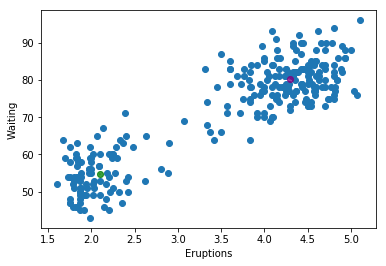

In [22]:
# plot results
plt.scatter(df['eruptions'].astype('float'), df['waiting'].astype('float'))
plt.plot(class1[:, 0], class1[:, 1], '-', marker = 'o', c='green', alpha=0.5)
plt.plot(class2[:, 0], class2[:, 1], '-', marker = 'o', c='purple', alpha=0.5)
plt.xlabel('Eruptions')
plt.ylabel('Waiting')

In [23]:
num_iters = []
for i in range(50):
    gmm = GaussianMixture(n_components=2, covariance_type = 'spherical', \
                            init_params = 'kmeans')
    gmm.fit(df)
    num_iters.append(gmm.n_iter_)

Text(0,0.5,'Number of iterations')

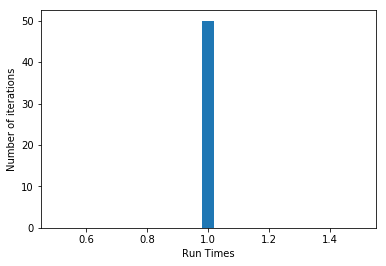

In [24]:
# plot histogram results
plt.hist(num_iters, bins = 25);
plt.xlabel('Run Times')
plt.ylabel('Number of iterations')

# Multidimensional scaling for genetic population differences

In [2]:
# import libraries
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from pyclustering.cluster.kmedoids import kmedoids
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from pyclustering.cluster import cluster_visualizer
import pylab as pl
data = np.load("mds-population.npz")
print (data['D']) # Distance matrix
print (data['population_list']) # List of populations

[[  0.  87.  12. ... 462. 559. 553.]
 [ 87.   0.  87. ... 210. 359. 285.]
 [ 12.  87.   0. ... 317. 401. 377.]
 ...
 [462. 210. 317. ...   0. 226. 173.]
 [559. 359. 401. ... 226.   0. 127.]
 [553. 285. 377. ... 173. 127.   0.]]
[b'Bantu' b'E. Afncan' b'Nilo-Saharan' b'W. African' b'San' b'Barter'
 b'Mbuti' b'Indian' b'Iranian' b'Near Eastern' b'Uralic' b'Ainu'
 b'Japanese' b'Korean' b'Mon Khmer' b'Thai' b'Dravidian' b'Mongol Tungus'
 b'Tibetan' b'Indonesian' b'Malaysian' b'Filipino' b'N. Turkic'
 b'S. Chinese' b'Basque' b'Lapp' b'Sardinian' b'Danish' b'English'
 b'Greek' b'Italian' b'C Amerind' b'Eskimo' b'Na-Dene' b'N. American'
 b'S. American' b'Chukchi' b'Melanesian' b'Micronesian' b'Polynesian'
 b'New Guinean' b'Australian']


#### a) Perform MDS and analyze the results

##### i) What we are doing with MDS

Assumptions being made: 
- the data can be represented by vectors along the set of dimensions indicated
- the dissimlarity is based on euclidean distance

Failure Circumstances: 
- data is clumpy instead of manifoldy
- if, for example, the principal directions of variation for a dataset are the first 3 dimensions, but we choose to only consider the first 2 dimensions for MDS

One way to measure how much information is being lost would be to apply MDS for the largest number of dimensions that we are willing to consider, then perform SVD on the resulting data to find the dimensions of greatest variation. Based on this we can optimize the number of dimensions that best represents the data and apply MDS again using this.

##### ii) How to Capture Most of the Variation in the Data

For this part, we decided to perform MDS for a high number of dimensions and check the eigenvalues of the result 
by performing SVD. Looking at the singular values in S (covariance matrix) obtained from SVD, we decided to consider the first 5 dimensions as the ones which give an accurate low-dimensional representation of the data because they were powers of 100. The rest of singular values were powers of 10 and 1, which is much smaller and thus less significant. We then used this finding to apply MDS with the first 5 dimensions.

In [6]:
# apply 20 dimensional MDS
embedding = MDS(n_components=20, dissimilarity = 'precomputed')
out_MDS_20 = embedding.fit_transform(data['D'])

# perform svd on the result
U_out, S_out, VTrans_out = sp.linalg.svd(out_MDS_20)

print(S_out) # found first 5 dimensions to be most significant

# apply 5 dimensional MDS
embedding = MDS(n_components=5, dissimilarity = 'precomputed')
out_MDS_5 = embedding.fit_transform(data['D'])

[7.18016282e+02 4.50061801e+02 3.72281465e+02 2.24121793e+02
 1.34223083e+02 8.49443282e+01 7.61661834e+01 6.31730897e+01
 1.86060588e+01 1.35615621e+01 9.13721490e+00 6.93465136e+00
 2.27454036e+00 1.12854761e+00 6.96490905e-01 5.34583845e-01
 2.05048679e-01 8.22323327e-02 2.58036780e-02 1.95465503e-02]


##### iii) Apply 2D MDS and Show Result

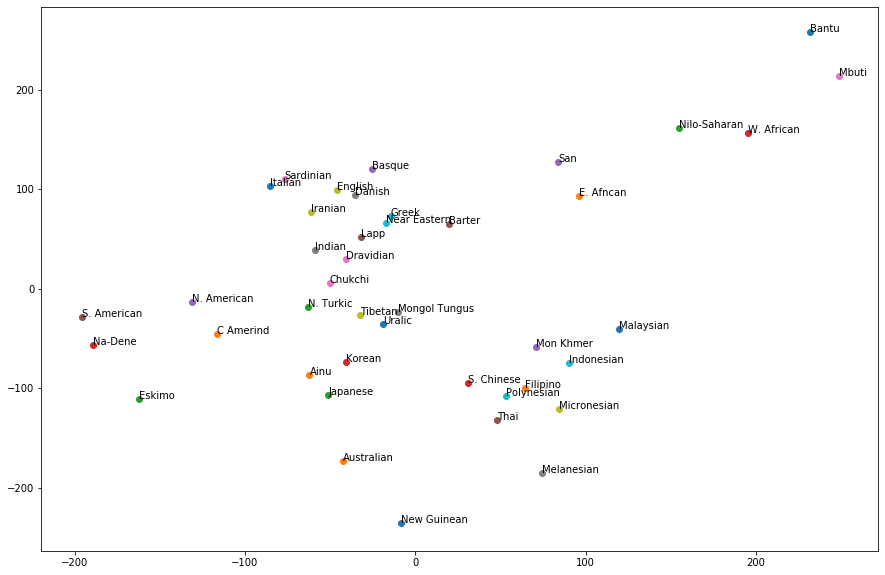

In [7]:
# apply 2 dimensional MDS
embedding = MDS(n_components=2, dissimilarity = 'precomputed')
out_MDS = embedding.fit_transform(data['D'])

plt.figure(figsize=(15,10))

# display and label results
for i, label in enumerate(data['population_list']):
    plt.scatter(out_MDS[i, 0], out_MDS[i, 1])
    plt.text(out_MDS[i, 0], out_MDS[i, 1], label.decode('utf-8'))
    
plt.savefig('MDS')

#### b) k-means on 2d embedding

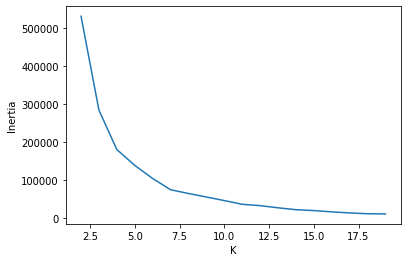

In [10]:
# find the best k
sil = []
ks = []
dists = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters = k, max_iter = 10000).fit(out_MDS)
    labels = kmeans.labels_
    
    # determine whether the documents are labeled correctly
    sil.append(silhouette_score(out_MDS, labels, metric = 'euclidean'))
    dists.append(kmeans.inertia_)

    ks.append(k)
    
plt.plot(ks, dists) # plot intertia for each ks
plt.xlabel('K')
plt.ylabel('Inertia')
plt.savefig('2DKmeans_Inertia.png')

This is the plot of intertia. The "elbow" of this plot is at k=6. This is the point at which we have achieved the best sum of square distance from the cluster center that we can before overfitting.

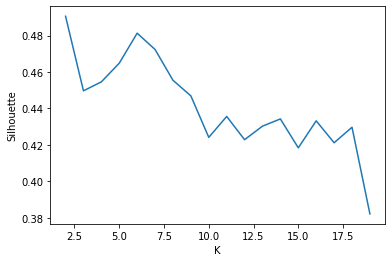

In [11]:
plt.plot(ks, sil) # plot silhouette score for every k
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.savefig('2DKmeans_Sil.png')

Above is a plot of the silhouette score. The silhouettes are all pretty high, so this make it difficult to choose k. This plot peaks at k=2, however, it also peaks similarly at k=6 like the elbow of the inertia plot tells us. From visually inspecting the data, however, it looks like the data does not really fall into 6 classes; the 2 class class seems more plausible from the way the data looks. So we decided to choose k=2. 

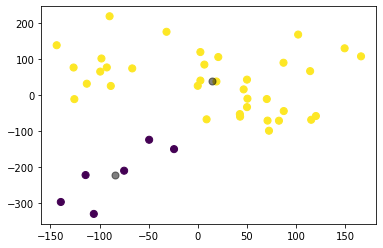

In [38]:
# run k-means on data with best k 
kmeans_best = KMeans(n_clusters = 2, max_iter = 10000).fit(out_MDS)
kmeans_best.fit(out_MDS)
y_kmeans = kmeans_best.predict(out_MDS)
centers = kmeans_best.cluster_centers_

# plot results
plt.scatter(out_MDS[:, 0], out_MDS[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.5)
plt.savefig('kmeans_4')

If we choose k=6: It looks like the clusters clusterby region on Earth pretty well. However, there are some discrepancies such as Indians and Dravidians being clustered with Europeans and Turkish being clustered with some of the East Asian countries. It does a pretty good job of separating out Americas, Africa, and countries around Austrailia, but the rest are kind of mixed together. This is likely due to the dimensionality reduction.

If we choose k=2: We don't fully agree with the clustering results because it also looks like there could be 3 clusters, or even more. However, the clustering does a good job of separating the African Countries from the rest of the data. The dimensionality reduction has caused the data to be in a more compacted space impacting how we cluster. The information about what features the distance is being calculated on is vital for understanding and representing the data, as well as for figuring out if the clusters make sense.

#### c) Comparing hierarchical clustering with k-means

C:\Users\simir\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


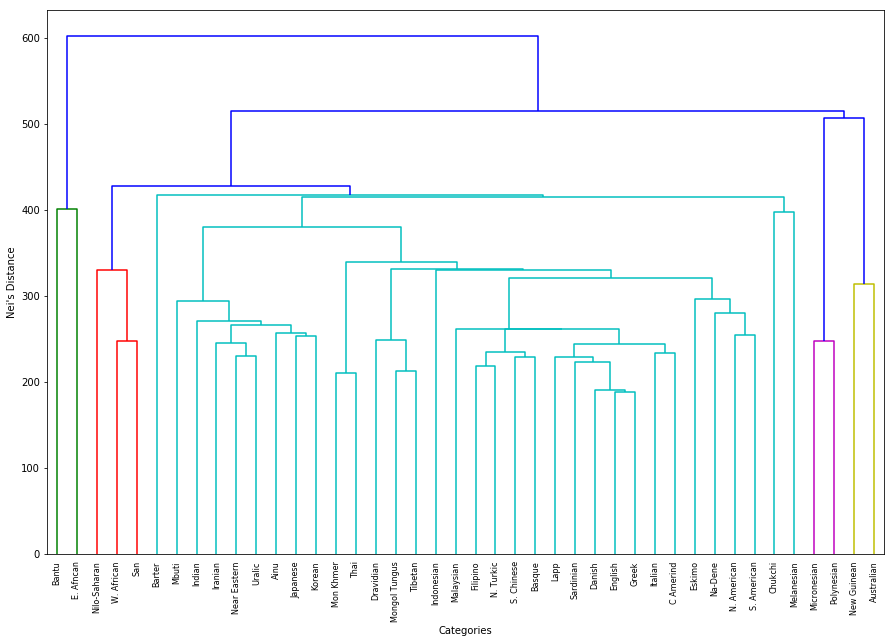

In [9]:
# obtain dendogram of the data
Z = linkage(data['D'])
plt.figure(figsize=(15,10))
dn = dendrogram(Z, no_plot = True)
labels = data['population_list']
lenght = len(labels)

# create a dictionary for the labels
temp = {dn["leaves"][ii]: labels[ii].decode('utf-8') for ii in range(len(dn["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

# dendogram with the labels we want
dn = dendrogram(Z, leaf_label_func=llf)

# plot hierarchical clustering results
plt.xlabel('Categories')
plt.ylabel('Nei\'s Distance')
plt.savefig('hierarchy')

In [10]:
# turn resulting tree into flat clustering of points
flat_clusters = fcluster(Z, t=601.38, criterion='distance') # using a threshold of 601.38 for the distance we get two clusters (k=2) 
# and most of the points assigned to the second cluster, like in k-means above

# (if k = 6 using a threshold of 416.95)

print(flat_clusters)

[1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2]


Colors Array Shape:  (42,)


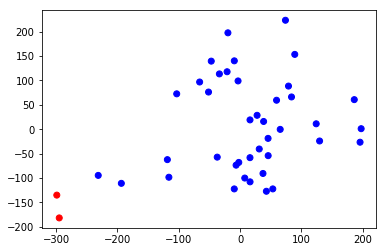

In [11]:
# plot results
colors = [] # to store colour of each point to in the scatterplot

# display results
for i, element in enumerate(flat_clusters):
    if(element == 1):
        colors.append("red")
    else:
        colors.append("blue")

colors_array = np.asarray(colors)

# check it is the right size and the code is working properly
print("Colors Array Shape: ", colors_array.shape)

# display results
plt.scatter(out_MDS[:, 0], out_MDS[:, 1], c=colors)
plt.savefig('flat_clusters')

Compared to the k-means clustering computer earlier, this technique groups more points into the second cluster. The first cluster in this case only contains 2 points. The k-means clustering results look more realistic and efficient.

#### d) k-medoids comparison with k-means

In [7]:
dat = data['D']
max(dat.flatten())

651.0

In [3]:
!pip install pyclustering

  Stored in directory: C:\Users\evatr\AppData\Local\pip\Cache\wheels\64\8c\62\f45c1df20df691f3dfb2c71be53660cf5d46a98f5c3fa53cec
Successfully built pyclustering


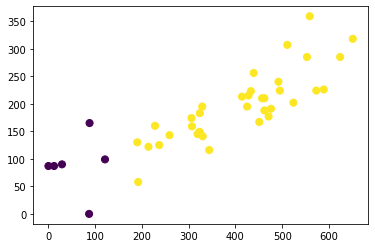

In [13]:
# apply k-medoids clustering to data
init_medoids = [1, 10]

# Create instance of k-medoids
kmedoids1 = kmedoids(data['D'], init_medoids, itermax = 100)

# obtain k-medoids results
kmedoids1.process()
medoids = kmedoids1.get_medoids()
clusters = kmedoids1.get_clusters()
c_kmedoids = kmedoids1.predict(data['D'])

# show clusters
plt.scatter((data['D'])[:, 0], (data['D'])[:, 1], c = c_kmedoids, s=50, cmap='viridis')
plt.savefig('k-medoids')